In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
relu = nn.ReLU()

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3)

    def forward(self, x):
        x = self.conv1(x)
        x = relu(x)
        x = self.conv2(x)
        x = relu(x)
        return x


In [3]:
class DecoderConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # output_size = (input_size - 1) * stride + kernel_size - 2 * padding
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2) 
        self.conv = DoubleConv(out_channels, out_channels)

    def forward(self, x, x1):
        y1 = self.up_conv(x)
        y2 = torch.cat((y1, x1))
        y = self.conv(y2)
        return y

In [4]:
class UNet(nn.Module):
    def __init__(self, input_channels=1):
        super().__init__()

        # non trainable layers
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # trainable layers
        ## encoder 
        self.en_conv1 = DoubleConv(input_channels,32)
        self.en_conv2 = DoubleConv(32,64)
        self.en_conv3 = DoubleConv(64,128)
        self.en_conv4 = DoubleConv(128,256)
        
        ## bottleneck
        self.conv = DoubleConv(256,512)

        ## decoder
        self.de_conv4 = DecoderConv(512,256)
        self.de_conv3 = DecoderConv(256,128)
        self.de_conv2 = DecoderConv(128,64)
        self.de_conv1 = DecoderConv(64,32)
        
        ## reconstruct layer
        self.reconstruct = nn.Conv2d(32, 3, kernel_size=3)

    def forward(self, x):
        # encoder inference 
        e1 = self.en_conv1(x)
        p1 = self.pool(e1)
        
        e2 = self.en_conv2(p1)
        p2 = self.pool(e2)
        
        e3 = self.en_conv3(p2)
        p3 = self.pool(e3)
        
        e4 = self.en_conv3(p3)
        p4 = self.pool(e4)
        
        # bottleneck inference
        b = self.conv(p4)
        
        # decoder inference 
        d4 = self.de_conv4(b,e4)
        d3 = self.de_conv3(d4,e3)
        d2 = self.de_conv2(d3,e2)
        d1 = self.de_conv1(d2,e1)

        # reconstruct image
        colored_image = self.reconstruct(d1)


        
        return colored_image

In [5]:
class GrayscaleCIFAR100(Dataset):
    def __init__(self,root='./data', train=True, transform=None):
        self.cifar100 = datasets.CIFAR100(root=root, train=train, download=True)
        self.transform = transform
        self.grayscale = transforms.Grayscale()

    def __len__(self):
        return len(self.cifar100)

    def __getitem__(self, index):
        image, label = self.cifar100[index]
        
        # Convert the image to grayscale
        
        grayscale_image = self.grayscale(image)

        # Apply transformations if provided
        if self.transform is not None:
            grayscale_image = self.transform(grayscale_image)
            image = self.transform(image)
        
        return grayscale_image, image

In [6]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

In [8]:
train_data = GrayscaleCIFAR100(
    root='./data',
    train=True,
    transform=transforms.ToTensor()
)

test_data = datasets.CIFAR100(
    root='./data',
    train=False,
    transform=transforms.ToTensor()
)


Files already downloaded and verified


In [9]:
train_data.transform = transform
test_data.transform = transform

In [10]:
# Create data loaders
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images
data_iter = iter(train_loader)
grayscaled, colored = next(data_iter)


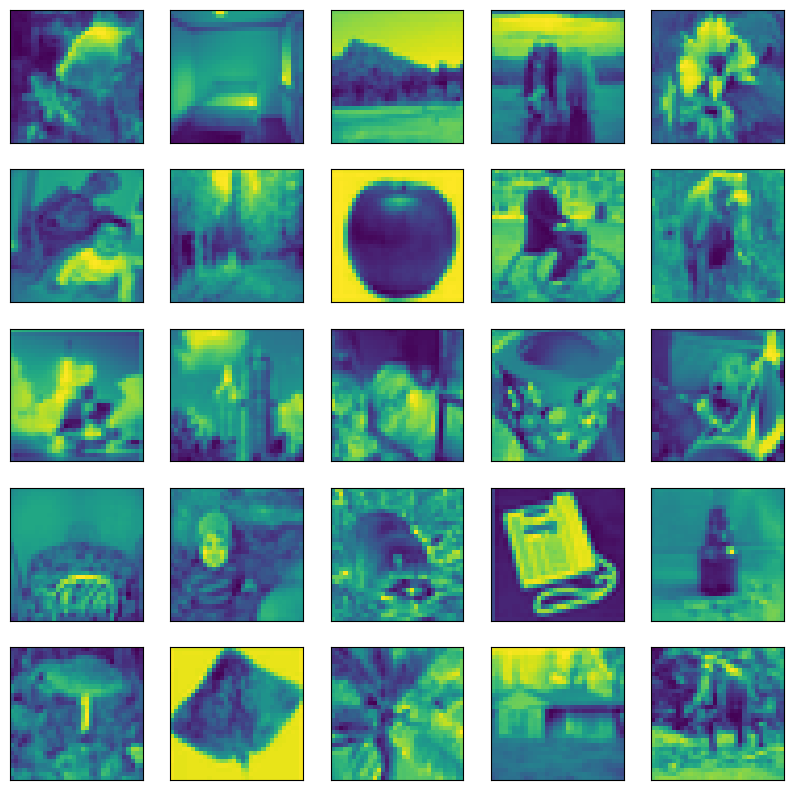

In [21]:

# Plot the images
fig = plt.figure(figsize=(10, 10))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    gray = grayscaled[i] 
    gray = np.transpose(gray.numpy(), (1, 2, 0))
    ax.imshow(gray)
plt.show()

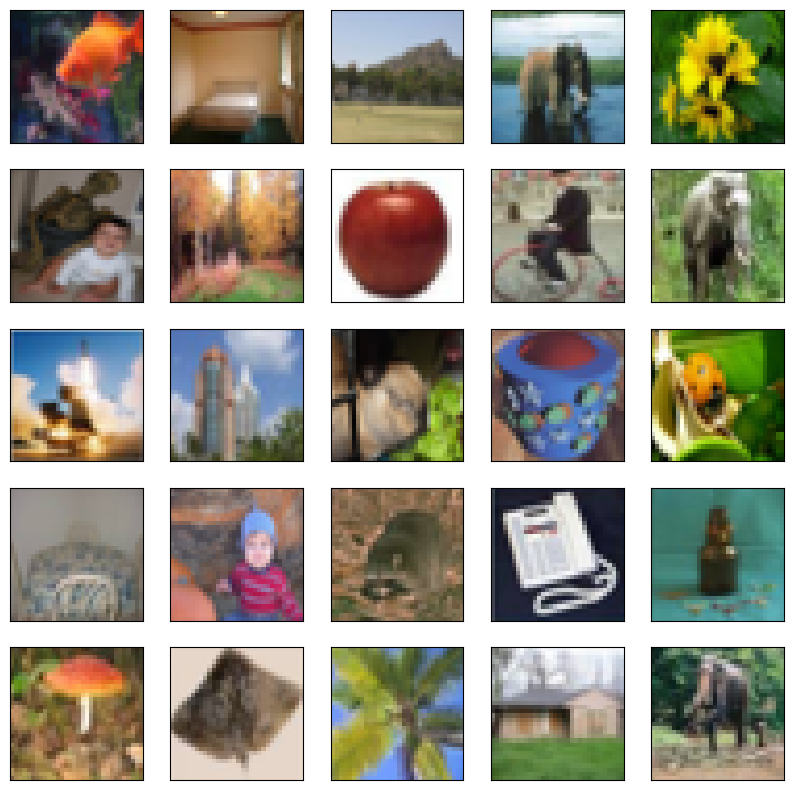

In [22]:
# Plot the images
fig = plt.figure(figsize=(10, 10))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    color = colored[i] 
    color = np.transpose(color.numpy(), (1, 2, 0))
    ax.imshow(color)
plt.show()